In [1]:
import numpy as np
import scipy.sparse as sp

In [43]:
def mean_average_precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.isin(recommendations, relevant_items, assume_unique=True)
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score


def evaluator(recommender: object, urm_test:sp.csr_matrix, cutoff = 10):
    recommendation_length = cutoff
    accum_precision = 0
    accum_recall = 0
    accum_map = 0
    urm_train = recommender.get_URM_train()
    num_users = urm_train.shape[0]
    interactions_per_user = np.diff(urm_train.indptr)
    user_map = []
    user_ids = []
    user_inter = []
    num_users_evaluated = 0
    num_users_skipped = 0
    for user_id in range(num_users):
        user_profile_start = urm_test.indptr[user_id]
        user_profile_end = urm_test.indptr[user_id + 1]

        relevant_items = urm_test.indices[user_profile_start:user_profile_end]

        if relevant_items.size == 0:
            num_users_skipped += 1
            continue

        recommendations = recommender.recommend(user_id_array=user_id,
                                                cutoff=recommendation_length)

        MAP = mean_average_precision(recommendations, relevant_items)
        
        num_users_evaluated += 1
        
        user_ids.append(user_id)
        user_map.append(MAP)
        user_inter.append(interactions_per_user[user_id])
    user_map = np.array(user_map)
    user_ids = np.array(user_ids, dtype=np.int32)
    user_inter = np.array(user_inter, dtype=np.int32)    
    return user_ids, user_map, user_inter


In [45]:
def interval_map(user_map, step = 10):
    result = {}
    for start in range(0, max(user_map[2]),step):
        end = min(start+step, max(user_map[2]))
        map_sum = 0
        inter_count = 0
        counter = 0
        for inter in user_map[2]:
            if inter <= end and inter > start:
                map_sum += user_map[1][counter]
                inter_count += 1
            counter += 1
        if map_sum == 0:
            continue
        map_sum /= inter_count
        interval = str(start) + '-' + str(end)
        result[interval]=map_sum
    return result

In [35]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
def plot_dic(result):
    figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    axes = plt.gca()
    axes.set_ylim([0,0.3])
    plt.bar(range(len(result)), list(result.values()), align='center')
    plt.xticks(range(len(result)), list(result.keys()))

In [5]:
def normalize_dict(result):
    result_norm = result.copy()
    sum_map = sum(result_norm.values())
    for item in result_norm.items():
        result_norm[item[0]]/=sum_map
    sum(result_norm.values())
    return result_norm
    

In [7]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from DataParser import DataParser
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

parser = DataParser()
URM_all = parser.get_URM_all()
ICM = parser.get_ICM_all()
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85, seed=1024)
SlimBPR = SLIM_BPR_Cython(URM_train)
SlimBPR.fit(topK= 860, epochs= 190, symmetric= False, sgd_mode= 'adam', lambda_i= 0.01, lambda_j= 1e-05, learning_rate= 0.0001)
user_map = evaluator(SlimBPR, URM_test)

SLIM_BPR_Recommender: URM Detected 42 (0.53 %) cold users.
SLIM_BPR_Recommender: URM Detected 1971 (7.59 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 7947 ( 100.00% ) in 0.61 seconds. BPR loss is 7.47E-07. Sample per second: 13013
SLIM_BPR_Recommender: Epoch 1 of 190. Elapsed time 0.07 sec
Processed 7947 ( 100.00% ) in 0.69 seconds. BPR loss is 5.24E-06. Sample per second: 11452
SLIM_BPR_Recommender: Epoch 2 of 190. Elapsed time 0.14 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 7.84E-06. Sample per second: 10598
SLIM_BPR_Recommender: Epoch 3 of 190. Elapsed time 0.20 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 1.27E-05. Sample per second: 9886
SLIM_BPR_Recommender: Epoch 4 of 190. Elapsed time 0.25 sec
Processed 7947 ( 100.00% ) in 0.85 seconds. BPR loss is 2

Processed 7947 ( 100.00% ) in 0.72 seconds. BPR loss is 9.23E-04. Sample per second: 11056
SLIM_BPR_Recommender: Epoch 52 of 190. Elapsed time 1.17 sec
Processed 7947 ( 100.00% ) in 0.73 seconds. BPR loss is 9.27E-04. Sample per second: 10874
SLIM_BPR_Recommender: Epoch 53 of 190. Elapsed time 1.18 sec
Processed 7947 ( 100.00% ) in 0.74 seconds. BPR loss is 9.85E-04. Sample per second: 10713
SLIM_BPR_Recommender: Epoch 54 of 190. Elapsed time 1.19 sec
Processed 7947 ( 100.00% ) in 0.75 seconds. BPR loss is 1.08E-03. Sample per second: 10543
SLIM_BPR_Recommender: Epoch 55 of 190. Elapsed time 1.20 sec
Processed 7947 ( 100.00% ) in 0.76 seconds. BPR loss is 9.86E-04. Sample per second: 10404
SLIM_BPR_Recommender: Epoch 56 of 190. Elapsed time 1.21 sec
Processed 7947 ( 100.00% ) in 0.77 seconds. BPR loss is 1.13E-03. Sample per second: 10270
SLIM_BPR_Recommender: Epoch 57 of 190. Elapsed time 1.22 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 1.09E-03. Sample per second: 101

Processed 7947 ( 100.00% ) in 0.26 seconds. BPR loss is 2.46E-03. Sample per second: 30940
SLIM_BPR_Recommender: Epoch 106 of 190. Elapsed time 1.71 sec
Processed 7947 ( 100.00% ) in 0.27 seconds. BPR loss is 2.52E-03. Sample per second: 29780
SLIM_BPR_Recommender: Epoch 107 of 190. Elapsed time 1.72 sec
Processed 7947 ( 100.00% ) in 0.28 seconds. BPR loss is 2.51E-03. Sample per second: 28809
SLIM_BPR_Recommender: Epoch 108 of 190. Elapsed time 1.72 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 2.56E-03. Sample per second: 27802
SLIM_BPR_Recommender: Epoch 109 of 190. Elapsed time 1.73 sec
Processed 7947 ( 100.00% ) in 0.29 seconds. BPR loss is 2.63E-03. Sample per second: 26953
SLIM_BPR_Recommender: Epoch 110 of 190. Elapsed time 1.74 sec
Processed 7947 ( 100.00% ) in 0.30 seconds. BPR loss is 2.54E-03. Sample per second: 26069
SLIM_BPR_Recommender: Epoch 111 of 190. Elapsed time 1.75 sec
Processed 7947 ( 100.00% ) in 0.31 seconds. BPR loss is 2.73E-03. Sample per secon

SLIM_BPR_Recommender: Epoch 159 of 190. Elapsed time 2.22 sec
Processed 7947 ( 100.00% ) in 0.78 seconds. BPR loss is 4.28E-03. Sample per second: 10222
SLIM_BPR_Recommender: Epoch 160 of 190. Elapsed time 2.23 sec
Processed 7947 ( 100.00% ) in 0.79 seconds. BPR loss is 4.21E-03. Sample per second: 10105
SLIM_BPR_Recommender: Epoch 161 of 190. Elapsed time 2.24 sec
Processed 7947 ( 100.00% ) in 0.80 seconds. BPR loss is 4.43E-03. Sample per second: 9978
SLIM_BPR_Recommender: Epoch 162 of 190. Elapsed time 2.25 sec
Processed 7947 ( 100.00% ) in 0.81 seconds. BPR loss is 4.43E-03. Sample per second: 9866
SLIM_BPR_Recommender: Epoch 163 of 190. Elapsed time 2.25 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 4.44E-03. Sample per second: 9746
SLIM_BPR_Recommender: Epoch 164 of 190. Elapsed time 2.26 sec
Processed 7947 ( 100.00% ) in 0.82 seconds. BPR loss is 4.37E-03. Sample per second: 9639
SLIM_BPR_Recommender: Epoch 165 of 190. Elapsed time 2.27 sec
Processed 7947 ( 100.00%

In [112]:
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.fit(topK=120, l1_ratio=1e-5, alpha=0.066)
user_map = evaluator(recommender_slim, URM_test)

SLIMElasticNetRecommender: URM Detected 42 (0.53 %) cold users.
SLIMElasticNetRecommender: URM Detected 1971 (7.59 %) cold items.
SLIMElasticNetRecommender: Processed 9133 ( 35.16% ) in 5.00 min. Items per second: 30.42
SLIMElasticNetRecommender: Processed 19788 ( 76.18% ) in 10.00 min. Items per second: 32.96
SLIMElasticNetRecommender: Processed 25975 ( 100.00% ) in 12.88 min. Items per second: 33.61


In [15]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
recommender_knn = ItemKNNCBFRecommender(URM_train, ICM)
recommender_knn.fit(shrink=1000.0, topK=40, similarity = 'cosine', feature_weighting = 'BM25')

ItemKNNCBFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCBFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 5414.30 column/sec, elapsed time 0.08 min


In [13]:
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython,\
    MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython

recommender = MatrixFactorization_BPR_Cython(URM_train)
recommender.fit(epochs = 220,
                   batch_size = 4,
                   num_factors=200,
                   learning_rate = 0.1,
                   sgd_mode='adam',
                   positive_reg = 1e-5, negative_reg = 0.01)

MatrixFactorization_BPR_Cython_Recommender: URM Detected 42 (0.53 %) cold users.
MatrixFactorization_BPR_Cython_Recommender: URM Detected 1971 (7.59 %) cold items.
MF_BPR: Processed 7944 ( 99.95% ) in 1.42 seconds. BPR loss 4.99E+01. Sample per second: 5598
MF_BPR: Epoch 1 of 220. Elapsed time 0.45 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.81 seconds. BPR loss 8.48E+02. Sample per second: 9836
MF_BPR: Epoch 2 of 220. Elapsed time 0.83 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.21 seconds. BPR loss 3.63E+03. Sample per second: 6571
MF_BPR: Epoch 3 of 220. Elapsed time 1.23 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.59 seconds. BPR loss 8.37E+03. Sample per second: 13529
MF_BPR: Epoch 4 of 220. Elapsed time 1.63 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.99 seconds. BPR loss 1.62E+04. Sample per second: 7996
MF_BPR: Epoch 5 of 220. Elapsed time 2.02 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.38 seconds. BPR loss 2.52E+04. Sample per second: 5752
MF_BPR: Epoch 6 of 220. Elapsed time 2.41

MF_BPR: Epoch 57 of 220. Elapsed time 21.60 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.95 seconds. BPR loss 1.55E+06. Sample per second: 8401
MF_BPR: Epoch 58 of 220. Elapsed time 21.97 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.31 seconds. BPR loss 1.54E+06. Sample per second: 6072
MF_BPR: Epoch 59 of 220. Elapsed time 22.33 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.67 seconds. BPR loss 1.58E+06. Sample per second: 11810
MF_BPR: Epoch 60 of 220. Elapsed time 22.70 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.04 seconds. BPR loss 1.61E+06. Sample per second: 7626
MF_BPR: Epoch 61 of 220. Elapsed time 23.07 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.41 seconds. BPR loss 1.61E+06. Sample per second: 19296
MF_BPR: Epoch 62 of 220. Elapsed time 23.44 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.78 seconds. BPR loss 1.65E+06. Sample per second: 10202
MF_BPR: Epoch 63 of 220. Elapsed time 23.80 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.14 seconds. BPR loss 1.66E+06. Sample per second: 6952
MF_

MF_BPR: Epoch 115 of 220. Elapsed time 42.25 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.58 seconds. BPR loss 2.26E+06. Sample per second: 13775
MF_BPR: Epoch 116 of 220. Elapsed time 42.60 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.93 seconds. BPR loss 2.26E+06. Sample per second: 8570
MF_BPR: Epoch 117 of 220. Elapsed time 42.95 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.26 seconds. BPR loss 2.28E+06. Sample per second: 6303
MF_BPR: Epoch 118 of 220. Elapsed time 43.29 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.62 seconds. BPR loss 2.25E+06. Sample per second: 12846
MF_BPR: Epoch 119 of 220. Elapsed time 43.64 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.95 seconds. BPR loss 2.31E+06. Sample per second: 8320
MF_BPR: Epoch 120 of 220. Elapsed time 44.00 sec
MF_BPR: Processed 7944 ( 99.95% ) in 1.30 seconds. BPR loss 2.27E+06. Sample per second: 6094
MF_BPR: Epoch 121 of 220. Elapsed time 44.33 sec
MF_BPR: Processed 7944 ( 99.95% ) in 0.66 seconds. BPR loss 2.33E+06. Sample per second: 12

MF_BPR: Processed 7944 ( 99.95% ) in 0.35 seconds. BPR loss 2.47E+06. Sample per second: 22462
MF_BPR: Epoch 173 of 220. Elapsed time 1.04 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.70 seconds. BPR loss 2.41E+06. Sample per second: 11350
MF_BPR: Epoch 174 of 220. Elapsed time 1.05 min
MF_BPR: Processed 7944 ( 99.95% ) in 1.05 seconds. BPR loss 2.45E+06. Sample per second: 7542
MF_BPR: Epoch 175 of 220. Elapsed time 1.05 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.41 seconds. BPR loss 2.45E+06. Sample per second: 19347
MF_BPR: Epoch 176 of 220. Elapsed time 1.06 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.76 seconds. BPR loss 2.45E+06. Sample per second: 10405
MF_BPR: Epoch 177 of 220. Elapsed time 1.06 min
MF_BPR: Processed 7944 ( 99.95% ) in 1.12 seconds. BPR loss 2.45E+06. Sample per second: 7103
MF_BPR: Epoch 178 of 220. Elapsed time 1.07 min
MF_BPR: Processed 7944 ( 99.95% ) in 0.48 seconds. BPR loss 2.40E+06. Sample per second: 16705
MF_BPR: Epoch 179 of 220. Elapsed time 1.08 min
M

In [39]:
from GraphBased.RP3betaRecommender import RP3betaRecommender
recommender_apr = RP3betaRecommender(URM_all)
recommender_apr.fit(alpha=0.4530815441932864,  beta=0.008742088319964482, topK=104, normalize_similarity=False)

RP3betaRecommender: URM Detected 1079 (4.15 %) cold items.


0.0 [19089, 23600, 12409, 20095, 19709, 16630, 19480, 3165, 8431, 17257] [18131]
0.0 [4842, 2824, 3164, 18790, 11548, 575, 20323, 9549, 17336, 16249] [21181]
0.0 [22487, 12473, 3942, 20905, 5412, 18569, 17820, 24093, 6649, 14446] [23037]
0.0 [8097, 7494, 8322, 19089, 19709, 11535, 19874, 1240, 2459, 4878] [ 2754  5581  9014 20146 23895]
0.0 [4209, 22862, 19189, 1358, 24919, 23923, 20148, 23155, 21582, 11159] [1957]
0.0 [25407, 23154, 15691, 2426, 10594, 10834, 6878, 1583, 6734, 18392] [ 9427 19750]
0.0 [10132, 9609, 20666, 13944, 23600, 25358, 14038, 5416, 14291, 6076] [21260 21267]
0.0 [3556, 12906, 11361, 23361, 22923, 23026, 18751, 3070, 12375, 23919] [21184]
0.0 [22956, 7856, 3220, 12788, 12890, 23403, 17540, 20001, 21630, 16099] [4532 6141]
0.0 [20969, 25407, 11924, 1770, 11533, 6446, 4213, 10834, 19468, 23880] [1242]
0.0 [18500, 16999, 20918, 20644, 244, 22617, 19103, 12254, 21099, 16793] [ 9155 22286]
0.0 [17130, 24546, 9520, 12903, 12230, 25766, 12643, 1205, 22622, 13433] [1430

0.0 [18684, 5717, 20706, 21281, 17668, 13635, 22152, 18872, 25491, 20726] [13534]
0.0 [195, 5862, 10569, 13625, 25938, 9859, 11497, 14666, 21024, 10443] [2278]
0.0 [6088, 22646, 15459, 13541, 9851, 14418, 18190, 2333, 8811, 9591] [ 9050 11212]
0.0 [5497, 6139, 18330, 21872, 20820, 16871, 5475, 4215, 15394, 16897] [16648]
0.0 [10513, 21802, 6616, 11597, 20911, 15330, 13756, 15905, 18799, 10005] [22342]
0.0 [21920, 10730, 588, 20308, 25596, 19822, 9300, 24391, 6274, 14759] [18178]
0.0 [1397, 10592, 7487, 9060, 15275, 1188, 17860, 16810, 23678, 18499] [ 3551  7553  8491  9606 11848 12257 12676 19054 20026]
0.0 [11832, 16362, 4411, 615, 23020, 1393, 9018, 10249, 6952, 14395] [1816]
0.0 [24075, 5078, 25675, 9438, 14684, 4502, 10269, 10786, 12061, 5942] [22554]
0.0 [2426, 10594, 1583, 7991, 12818, 18392, 6734, 5044, 17156, 10981] [7095 8990]
0.0 [18293, 1366, 10073, 15915, 23004, 13752, 22750, 24216, 10753, 561] [10086]
0.0 [19089, 7494, 16630, 17723, 20146, 12409, 18984, 23600, 11658, 5522]

0.0 [25407, 16772, 17229, 13226, 23154, 484, 2426, 8990, 10594, 15691] [1583]
0.0 [25407, 2426, 23154, 13711, 1583, 18452, 9555, 23141, 10834, 3572] [10981]
0.0 [24093, 4803, 15764, 16857, 16084, 3148, 9187, 8304, 3068, 15125] [ 5934 22508]
0.0 [24075, 25675, 9851, 10786, 10269, 22554, 5942, 25693, 15564, 18293] [9438]
0.0 [15764, 8304, 8064, 24093, 18569, 18122, 5412, 4803, 17284, 16084] [ 9187 17820]
0.0 [10269, 25675, 12061, 9438, 10786, 5942, 19874, 18293, 13118, 773] [9851]
0.0 [3037, 8709, 9662, 20300, 9716, 13990, 7658, 22548, 15778, 6689] [ 2767  5032 24971]
0.0 [25407, 2426, 10594, 9555, 14684, 1583, 18419, 6734, 5581, 16775] [ 2184  2485  4257  6691 13228 13565 24405]
0.0 [24075, 9438, 10269, 13763, 8396, 2746, 919, 9241, 9819, 12454] [ 8513 10342 11994 21154]
0.0 [4742, 16624, 23766, 3612, 19547, 17481, 8869, 3931, 3352, 5341] [ 2830 17551 18540 20772 25329]
0.0 [13159, 16954, 4352, 2369, 25553, 21369, 25277, 7430, 21391, 20894] [17391]
0.0 [12717, 24075, 19863, 6279, 21704,

0.0 [11533, 8097, 3737, 19875, 25407, 12914, 5952, 13586, 8322, 15169] [25596]
0.0 [15566, 9691, 22757, 3352, 22749, 10278, 6111, 14118, 22769, 23482] [ 578 2318]
0.0 [2426, 25407, 6878, 18392, 23154, 21920, 12050, 10908, 5108, 10792] [8316]
0.0 [24075, 9438, 25675, 5942, 7117, 13677, 19089, 17771, 1100, 25216] [16294 18914 25438]
0.0 [25407, 23154, 10834, 16928, 2426, 23141, 10594, 7991, 9701, 5044] [7537]
0.0 [14684, 4502, 5581, 20308, 18419, 7883, 24355, 10418, 17668, 11737] [11876]
0.0 [12780, 11772, 25044, 11820, 17156, 4188, 22592, 4588, 23651, 8990] [22354]
0.0 [24075, 12061, 9438, 20496, 9851, 25071, 24410, 2426, 10786, 23666] [ 8538 10269 13283 15887 19018 19129 20169]
0.0 [24075, 23184, 2126, 16875, 5244, 21510, 20986, 22178, 18477, 1684] [ 5933 10747]
0.0 [11269, 13767, 17586, 3037, 14430, 22002, 15937, 25771, 7144, 5150] [6909]
0.0 [11792, 9243, 18163, 10514, 18692, 14433, 4055, 12983, 24202, 20362] [11067]
0.0 [15691, 2180, 8438, 4019, 20926, 9820, 8515, 18208, 4762, 8580]

0.0 [217, 10212, 20711, 5830, 2109, 22260, 3747, 20802, 19255, 19312] [23970]
0.0 [25407, 2426, 10594, 9555, 22010, 6734, 15691, 11533, 18392, 21042] [ 4231  5564  5581  9128 10509 11148 11814 11845 12300 13005 13921 15884
 16577 17070 18395 19713 22037 22348 23917 24379 25901]
0.0 [17400, 12230, 24945, 3722, 21002, 9520, 18343, 15677, 13552, 20857] [11623]
0.0 [10730, 3497, 22121, 13294, 17877, 6314, 2039, 1064, 51, 2492] [ 681 7271]
0.0 [25407, 2426, 9555, 23154, 10594, 1583, 12818, 16928, 18392, 7991] [10834]
0.0 [19874, 24355, 4502, 20308, 15234, 4257, 5581, 10418, 24070, 14413] [ 2159  3310 11711 17668]
0.0 [19089, 8894, 20146, 2665, 23600, 11295, 20095, 19709, 7494, 5044] [ 8785 10092 12409 16630 18544 24043]
0.0 [9511, 17517, 7144, 25083, 20841, 17546, 22075, 14554, 19973, 7568] [5772]
0.0 [5078, 25957, 8268, 14684, 21428, 1801, 22718, 21686, 24216, 2819] [15504 25141]
0.0 [15566, 9691, 22757, 11540, 471, 5967, 3790, 25659, 6433, 7797] [11854 21703]
0.0 [24075, 3551, 22554, 9438

0.0 [10390, 3788, 484, 13226, 2485, 2001, 15612, 23468, 15645, 5908] [19340]
0.0 [5717, 4620, 9284, 18190, 13541, 12341, 2333, 23536, 23711, 2868] [  878   999  1214  1776  3223  4335  6239 13715 15099 19159 19979 20626
 24841 25749]
0.0 [10269, 23071, 16828, 771, 25354, 14915, 25675, 9438, 10785, 19502] [  207 13855 23427 24075]
0.0 [2656, 5259, 20226, 13138, 4237, 14225, 18561, 14653, 17952, 15477] [4956 9998]
0.0 [10269, 25675, 9438, 12061, 9851, 22554, 13490, 10786, 5942, 5475] [13819 15394 17167]
0.0 [2426, 15691, 9555, 23154, 10834, 8990, 23141, 10594, 13711, 1583] [22655]
0.0 [24109, 24484, 17820, 8304, 4803, 6794, 10887, 18122, 6674, 12742] [   57 18351]
0.0 [2333, 13541, 18190, 23711, 4620, 12341, 2868, 10269, 23536, 12061] [14220 15082 15666 22858]
0.0 [16324, 3905, 20345, 13867, 12967, 14316, 25957, 2835, 16522, 2459] [ 5947  7651 11089 13617 19824 21227 23949 24711]
0.0 [13541, 2333, 5717, 18190, 6088, 9284, 9029, 11792, 15327, 12341] [25748]
0.0 [25477, 4871, 2887, 16255, 

0.0 [12087, 22743, 14654, 7283, 23583, 1057, 10802, 13517, 5227, 9591] [12080 12222]
0.0 [21552, 180, 8811, 10459, 466, 14166, 6719, 942, 16420, 13363] [206]
0.0 [7494, 19089, 20146, 12409, 24075, 16630, 15691, 22718, 6397, 22081] [ 8894 10975]
0.0 [24075, 9438, 18293, 10786, 10269, 12061, 12923, 5942, 15564, 3803] [25675]
0.0 [13226, 23651, 23468, 4194, 16793, 17013, 19340, 17401, 9123, 20766] [  484  2001 17317]
0.0 [17586, 4218, 9741, 10747, 8432, 25192, 5510, 19421, 24336, 2863] [21081 24676]
0.0 [19874, 18419, 4502, 14684, 1714, 15363, 22181, 24410, 6132, 8544] [ 5608  5734 13329 18394 25632]
0.0 [6893, 21344, 9633, 9663, 10432, 14132, 1237, 17824, 7197, 13693] [10720]
0.0 [23154, 6734, 23141, 9555, 2551, 10594, 11431, 16197, 6314, 19525] [ 2305 15703]
0.0 [20146, 12409, 21, 21037, 19089, 17409, 15535, 23896, 23241, 13819] [ 1031 18776]
0.0 [21677, 19007, 5446, 25526, 18852, 4738, 12230, 5283, 1205, 304] [ 1700 17969 25839]
0.0 [24075, 22554, 9438, 10786, 18293, 12061, 10269, 9851

0.0 [25407, 15691, 10834, 9555, 22121, 23154, 1583, 10594, 23141, 9701] [ 8990 25044]
0.0 [466, 7992, 19389, 8538, 10327, 12948, 6636, 24577, 16799, 13711] [25333]
0.0 [19089, 23481, 19709, 20146, 7494, 16630, 23600, 5522, 12409, 17723] [817]
0.0 [16772, 25407, 8097, 15691, 17877, 21042, 1463, 6454, 2426, 20410] [ 1005  7329 12943 13057 17651]
0.0 [1495, 19534, 4257, 16394, 1230, 24070, 7547, 15844, 18419, 16955] [21053]
0.0 [5664, 25250, 3092, 7970, 5414, 17948, 2122, 16197, 10615, 3556] [24425]
0.0 [15559, 18793, 9716, 8709, 5032, 7611, 7267, 15778, 497, 22835] [ 3737 24388]
0.0 [14684, 4502, 19874, 25932, 20308, 21697, 6612, 6500, 4257, 10418] [10857]
0.0 [13226, 18469, 24948, 16267, 9041, 10426, 8826, 7753, 10691, 10537] [11121]
0.0 [19468, 16772, 14272, 15729, 8990, 15691, 23154, 9673, 5784, 4909] [3432]
0.0 [1397, 3506, 12839, 6319, 12257, 7553, 10592, 23426, 15275, 7487] [24452]
0.0 [11083, 10337, 6691, 14983, 7539, 11832, 1816, 15124, 24070, 14902] [21512]
0.0 [7259, 15451, 198

0.0 [25169, 2932, 3619, 18268, 773, 19089, 17192, 19239, 9591, 8251] [13398 14291 23397]
0.0 [15881, 4100, 14605, 4979, 18122, 1897, 19118, 19824, 21005, 6414] [24284]
0.0 [19832, 10420, 6011, 18373, 21001, 16908, 6962, 6166, 1660, 10269] [  413  2242  3082  4230  6673  7801 13441 14795 15630 17713 18870 19548
 23956 24763]
0.0 [14684, 19874, 24355, 20308, 4257, 7883, 10418, 5581, 18419, 20368] [4502]
0.0 [5952, 3737, 19874, 4257, 3580, 14684, 4502, 20308, 654, 23774] [  358  2118  7477 23448]
0.0 [22554, 7728, 16819, 21469, 11459, 5078, 13465, 561, 16902, 195] [25111]
0.0 [14684, 4502, 702, 877, 19874, 17019, 20308, 6612, 4257, 10418] [24355]
0.0 [17503, 9943, 773, 21552, 22448, 19062, 19167, 4620, 22657, 18268] [5973]
0.0 [11533, 25407, 3737, 8860, 4541, 8984, 2118, 20974, 2789, 25133] [16724 25596]
0.0 [4152, 22282, 14137, 19874, 4913, 6183, 3636, 18512, 16981, 7883] [ 7585  9209 14158 17305 17464]
0.0 [9591, 1863, 15764, 2996, 17820, 20950, 15143, 18080, 21005, 24093] [533]
0.0 [22

0.0 [10269, 22554, 5942, 12061, 10786, 18293, 9851, 15564, 19401, 13118] [25675]
0.0 [23568, 3761, 6356, 25390, 24340, 18545, 11741, 11206, 15626, 3645] [5067]
0.0 [1959, 16473, 19007, 18656, 17130, 22076, 8475, 1745, 25209, 20857] [11623]
0.0 [9531, 17546, 3971, 13665, 10766, 18636, 2723, 15903, 17517, 4112] [12698 19287]
0.0 [18293, 22128, 19874, 25046, 6502, 4502, 4927, 6294, 12710, 22862] [  313  2604 13797 22606]
0.0 [25407, 2426, 10834, 6734, 15691, 17156, 9701, 8316, 16928, 18452] [ 2293 10981 11834 12050 23154]
0.0 [5349, 10042, 4055, 24497, 2008, 10514, 12196, 3277, 15737, 11067] [12192 13759 24469]
0.0 [20394, 17157, 9787, 6450, 1714, 8630, 4818, 21167, 23137, 13798] [18243]
0.0 [17257, 13797, 23310, 2468, 12782, 23620, 23434, 19571, 20782, 10062] [18394]
0.0 [780, 1852, 15607, 4811, 752, 11129, 16823, 10176, 991, 5135] [ 1274  1395  6005  8344  8577  9512 10277 11187 13111 13290 14212 16220
 21090 21192 24046 25474]
0.0 [5942, 24075, 23799, 11080, 10028, 5044, 10269, 5774, 1

0.0 [7117, 9022, 22428, 22043, 11869, 350, 5370, 24363, 154, 7590] [12003]
0.0 [5032, 8709, 18793, 13231, 21321, 12158, 16941, 20190, 9716, 10544] [14550]
0.0 [16793, 22594, 9992, 8955, 10162, 12601, 13226, 3432, 8249, 8990] [4390]
0.0 [7494, 13336, 8894, 2533, 8431, 23481, 11658, 22558, 12409, 19089] [ 7941  9027 17516]
0.0 [15774, 17973, 388, 25395, 21087, 1879, 18505, 25518, 17518, 10496] [6865]
0.0 [24075, 9438, 9851, 23711, 10786, 3803, 19114, 18872, 21854, 23536] [   18   319   353   364   872   958  1158  1274  1504  1611  2015  2207
  2365  2371  2688  2839  3149  3164  3540  3826  3865  4124  4665  4947
  5380  5717  6012  6041  6559  6573  7494  7794  7909  8667  9999 10514
 10642 10648 11144 11266 11314 11683 11792 12655 12657 13004 13324 13985
 14066 14816 14895 14934 15510 15544 15587 15691 15888 16189 16307 16311
 16494 16635 17424 19089 19566 19836 19844 19935 20230 20536 21077 21767
 22003 22080 22326 22420 22483 22723 22738 22823 22839 23159 23194 23254
 23371 23377 23

0.0 [6872, 17835, 4834, 9851, 20553, 126, 18732, 7717, 7034, 17598] [ 4599  5627  9020 13371 16563 20457 20626 24211 24754]
0.0 [2426, 25407, 6734, 1583, 9555, 10834, 15691, 6878, 22848, 18392] [10594 12118]
0.0 [16648, 25819, 15098, 24948, 20410, 25407, 5497, 5044, 10653, 19346] [8249]
0.0 [4825, 1397, 23989, 914, 9358, 7587, 12158, 14253, 44, 18863] [20610]
0.0 [5486, 24672, 22006, 1649, 20855, 3145, 12047, 5467, 18476, 1063] [16020 18169 22308]
0.0 [24458, 11383, 16715, 11721, 16014, 20844, 18949, 5824, 11231, 23748] [8912]
0.0 [3201, 19189, 16019, 10765, 25162, 8329, 13369, 12252, 5813, 7624] [18394]
0.0 [5717, 9284, 4620, 6088, 2868, 15459, 12061, 15327, 2300, 3983] [ 1625  2333  3835  7997 10450 10788 14159 14311 20737 23266 23299 24561]
0.0 [17586, 7981, 6629, 25890, 7662, 9774, 13954, 17370, 8843, 8229] [8084]
0.0 [19518, 13763, 10994, 592, 16489, 11871, 7426, 25702, 13388, 9241] [5187]
0.0 [24410, 21552, 8544, 8036, 20108, 14023, 1167, 11089, 8920, 11384] [4312]
0.0 [7981, 109

0.0 [23600, 10829, 19487, 6827, 22534, 11677, 4092, 3541, 12872, 22402] [12622 18420]
0.0 [25407, 10834, 9555, 23154, 10594, 5044, 1583, 18392, 22121, 19089] [ 2426 15691 17770 24670 25408]
0.0 [12214, 18419, 12162, 20308, 7006, 24577, 12914, 19823, 10418, 25834] [  115  3775  7946  8268  8675 13439 16782 19150 19627 21373 24138 25838]
0.0 [6272, 12943, 9873, 17078, 8624, 25096, 6944, 12521, 21449, 24202] [23659]
0.0 [7446, 19819, 11729, 11461, 3599, 11119, 5788, 6360, 6044, 17534] [3026]
0.0 [1863, 21552, 24075, 19094, 2996, 13541, 8560, 3009, 18893, 13764] [   19   749   998  2707  9591 21859]
0.0 [25407, 7144, 16775, 8097, 7426, 4118, 2426, 9555, 3037, 7494] [19825 25083]
0.0 [24075, 25675, 22554, 9438, 3803, 20146, 12755, 15564, 10269, 19564] [20487]
0.0 [12050, 13136, 2492, 18392, 2426, 10792, 5, 25407, 1056, 22010] [ 3447 10690]
0.0 [20146, 19709, 16630, 15691, 12409, 7494, 19480, 8894, 25407, 22445] [ 3572  5044  8972 12552 12776 13845 13944 19346]
0.0 [25407, 9555, 23154, 8990,

0.0 [12007, 13539, 16002, 2333, 11792, 974, 13424, 15140, 3595, 5100] [24281]
0.0 [15190, 6091, 5447, 24172, 11502, 5182, 14721, 4512, 16747, 15613] [15722]
0.0 [2333, 6088, 15459, 18190, 23711, 4620, 5717, 23536, 2868, 21854] [ 5498 10450 16753]
0.0 [16577, 2001, 11121, 20688, 10162, 16793, 23468, 6125, 21021, 23651] [  484 22226]
0.0 [10269, 25675, 9438, 14684, 12061, 4502, 9851, 22554, 10786, 5942] [  856 24355]
0.0 [24075, 9591, 25675, 9438, 18293, 23711, 10269, 773, 22617, 1863] [11549 19308 21741 23666]
0.0 [10758, 12734, 8733, 6740, 22588, 24522, 20496, 15010, 15333, 544] [5310]
0.0 [16394, 10134, 25407, 18414, 9683, 8322, 7742, 8097, 17070, 22840] [18882]
0.0 [8544, 2333, 19114, 23536, 13427, 24561, 13001, 1504, 8524, 1623] [10009]
0.0 [13424, 20747, 12158, 8709, 22608, 1885, 10540, 13789, 5905, 8467] [ 2760 13502]
0.0 [3812, 11366, 19089, 24484, 1770, 8502, 11533, 15304, 12409, 23448] [23880]
0.0 [22010, 20366, 1770, 19480, 10086, 13294, 23880, 20521, 20173, 10598] [22840]
0.0

0.0 [15196, 1863, 16179, 7646, 5150, 11072, 7235, 6443, 10462, 17546] [12289 21634]
0.0 [7006, 15749, 21512, 22065, 3497, 18747, 10727, 22121, 13294, 12591] [4855 7093]
0.0 [9514, 12818, 16906, 12197, 17415, 7228, 11594, 24193, 4491, 19831] [4765]
0.0 [15635, 25013, 22800, 2532, 399, 7109, 24794, 7030, 5942, 5650] [5834 8440]
0.0 [3236, 19079, 24503, 9243, 5487, 18791, 17774, 477, 19450, 1611] [11389]
0.0 [25675, 23600, 16630, 17723, 7494, 20146, 3165, 19480, 12061, 3803] [ 1576  2399  7847  8266  8431  9425 10269 12755 13433 15843 16850 17209
 19308 20193 21648 22853 24128 25286]
0.0 [4502, 17637, 18512, 20308, 2459, 16324, 25957, 24355, 18419, 24711] [ 4888  5713 14265 22653]
0.0 [5717, 18190, 12341, 15327, 4528, 16112, 3668, 562, 2333, 11792] [   11  3223  4515  4938  7349  9075 12413 13229 17107 17158 20344 22473
 23127 25562]
0.0 [9591, 22750, 8560, 25046, 6294, 21552, 22128, 22554, 5185, 25675] [25002]
0.0 [19326, 22951, 6226, 7839, 16124, 5210, 1700, 17066, 14289, 10308] [6369 7

0.0 [1397, 3506, 44, 20800, 10592, 9035, 7449, 19628, 6204, 10843] [18404]
0.0 [22554, 24075, 7202, 9438, 25260, 12923, 19564, 15564, 18293, 12061] [357]
0.0 [6239, 20108, 8544, 5562, 3934, 21653, 13219, 17522, 20148, 19398] [ 7639 18126 22712]
0.0 [22581, 3614, 24297, 15212, 25234, 23842, 13707, 21975, 17850, 10530] [9578]
0.0 [7494, 19089, 12409, 23600, 20095, 19709, 16630, 22121, 17723, 5044] [13260 15431]
0.0 [8689, 22814, 4095, 6346, 9880, 11826, 6217, 7501, 11220, 24075] [17538]
0.0 [25675, 10269, 9438, 12061, 9851, 23715, 9801, 13676, 7571, 20967] [2776]
0.0 [3744, 21061, 4147, 6164, 5469, 8529, 22564, 1869, 11848, 14141] [16400]
0.0 [6539, 4289, 24594, 13814, 2757, 24586, 25376, 6264, 292, 17317] [5626]
0.0 [7981, 8396, 9926, 22758, 14485, 12158, 10207, 5844, 10213, 22088] [25549]
0.0 [12061, 10269, 9438, 10786, 25675, 23711, 8811, 5942, 25071, 5717] [  773 13344 24896]
0.0 [20969, 11533, 25407, 3737, 1242, 7095, 7823, 6446, 15169, 19468] [3812]
0.0 [24666, 13132, 18999, 5374, 

0.0 [11702, 18547, 4635, 14231, 644, 3527, 16561, 12061, 9752, 2533] [12850 17180 22022]
0.0 [13541, 7885, 5717, 4620, 9284, 15327, 18190, 2333, 23127, 11987] [ 9925 17577]
0.0 [24075, 10269, 12061, 18293, 10786, 7202, 19401, 12755, 3803, 9851] [22554]
0.0 [7494, 12409, 23600, 20095, 19709, 19480, 23481, 17257, 20982, 8431] [6964 8138]
0.0 [11283, 11694, 5254, 2543, 12061, 18804, 8538, 16715, 5824, 10788] [23748]
0.0 [867, 12983, 12061, 25675, 11067, 19704, 9851, 8544, 10786, 24075] [ 4512  5988  6547  8811  9412 11093 24527 24896]
0.0 [22511, 21552, 10674, 24099, 19838, 3348, 14560, 9992, 24597, 2996] [5407]
0.0 [19875, 2426, 4541, 8834, 15169, 25596, 18566, 20863, 15976, 21920] [    5   349  1085  2522  2971  4166  4785  4987  5715  6660  7642  7957
  8925  9956 10882 13065 13542 15108 16516 16880 18187 20859 22929 23802
 24578 25133 25261 25407]
0.0 [4541, 20974, 358, 3737, 10882, 6708, 25080, 1085, 1840, 5952] [13953 15259 21352]
0.0 [6151, 17054, 6470, 3010, 23447, 3633, 16333, 48

0.0 [9992, 17998, 5767, 23106, 13526, 9380, 11578, 23309, 25635, 25044] [7397]
0.0 [12684, 3804, 780, 19100, 21996, 10341, 361, 6716, 12758, 8068] [752]
0.0 [25407, 24577, 12914, 17819, 17108, 9253, 21052, 5044, 15691, 19431] [21635]
0.0 [14684, 19874, 17668, 11737, 4502, 24355, 10418, 18512, 19189, 1947] [16116]
0.0 [18293, 22128, 8544, 6294, 9591, 22750, 24230, 11730, 15830, 22511] [ 6198  6422  7647 13174 19631 22293 23004 25046]
0.0 [8560, 9591, 17820, 1863, 5934, 24093, 24484, 9018, 18122, 3923] [4940]
0.0 [21100, 10547, 12367, 3326, 17366, 23566, 21357, 18730, 12334, 19911] [14269]
0.0 [8709, 22903, 3037, 9662, 18793, 9769, 20308, 8295, 5032, 17724] [ 5265  8563 11979 18102 24512]
0.0 [18798, 16577, 2877, 2888, 22121, 21355, 15691, 3382, 4502, 10834] [19033]
0.0 [2426, 6734, 23154, 10834, 25407, 9555, 18392, 21920, 9322, 23133] [10594]
0.0 [20969, 25407, 8528, 5887, 2190, 6446, 1242, 17286, 5250, 5673] [18814]
0.0 [6539, 4341, 13814, 24594, 24586, 10175, 25376, 4289, 292, 17322] 

0.0 [16394, 25407, 1794, 23086, 8322, 24172, 10653, 20508, 18263, 8097] [12214 19497 25135]
0.0 [24075, 9438, 25675, 10269, 25253, 5052, 6883, 15564, 13118, 3058] [3521]
0.0 [22121, 19033, 9992, 3812, 12936, 5930, 12943, 5044, 6446, 484] [17122 19335]
0.0 [14684, 24355, 19874, 24070, 24197, 18419, 10073, 10418, 386, 4257] [ 7714 17668 20258]
0.0 [24075, 22554, 10269, 9438, 2426, 17209, 12923, 10786, 18293, 12061] [11340]
0.0 [11774, 7494, 23600, 19480, 3527, 18214, 24546, 12490, 16630, 20146] [ 2021  2043  8478  9976 10249 10952 14314 17768 18134 22069]
0.0 [771, 10269, 10785, 1224, 16828, 25675, 9438, 6065, 23071, 12061] [17657 20023 24075]
0.0 [2333, 23711, 11792, 24075, 23536, 22356, 9851, 13541, 5717, 4620] [ 6401  8285  8783  9337 17218 21854 23972]
0.0 [2426, 23154, 24075, 10594, 6734, 15691, 9555, 18392, 25407, 22554] [1727]
0.0 [25407, 15691, 1583, 2426, 11979, 9555, 10834, 10594, 23154, 12818] [16928]
0.0 [8894, 6994, 11900, 2533, 316, 17257, 17018, 2665, 18317, 3428] [ 1753  

0.0 [8659, 16762, 21697, 10865, 5467, 4382, 2550, 20833, 20648, 17835] [11592 17750 19105]
0.0 [2426, 25407, 10594, 10834, 9555, 6734, 17156, 15691, 18392, 1583] [9701]
0.0 [8709, 14706, 3037, 19123, 5032, 24008, 25439, 2734, 5523, 12082] [6549]
0.0 [25407, 11533, 13136, 5952, 9733, 22010, 11340, 5, 23154, 2492] [14509 20270]
0.0 [11792, 5717, 4620, 23711, 9284, 11067, 6088, 13541, 9851, 23127] [ 6783  7849 21811]
0.0 [13541, 4620, 5717, 23536, 2333, 9284, 12341, 23711, 6088, 15327] [ 4707  5899  9191 18114]
0.0 [4502, 17668, 18419, 6612, 4257, 15363, 18512, 21697, 25479, 11737] [  349 14684 15856 20652 20948]
0.0 [16630, 8431, 16394, 8097, 5522, 12466, 24209, 20146, 7494, 14684] [16264 24070]
0.0 [22378, 19987, 6179, 3877, 1258, 2848, 15714, 9339, 2690, 12841] [6536]
0.0 [2747, 22374, 22887, 9883, 4101, 14994, 15519, 13248, 17316, 17314] [14259]
0.0 [4620, 23536, 18190, 23711, 2333, 21854, 19114, 23457, 2868, 9029] [  262   756  3176  5465  6705  8340  9218  9278  9345  9525 12341 133

0.0 [23600, 7494, 12409, 19480, 20095, 20146, 19709, 23481, 17723, 2665] [14838]
0.0 [13541, 5717, 2333, 4620, 24075, 18190, 23536, 2868, 12061, 15459] [2302 2707 7373]
0.0 [20095, 16630, 7494, 17723, 8894, 23600, 12409, 20146, 22121, 2665] [19525]
0.0 [25407, 10834, 2426, 9555, 13711, 6878, 2551, 1583, 18392, 15691] [24670]
0.0 [25693, 5494, 12313, 16220, 5273, 17115, 11777, 22469, 18790, 19899] [24955]
0.0 [7426, 5084, 25702, 8229, 21322, 16266, 7994, 5044, 21364, 24075] [12022]
0.0 [16489, 9438, 7426, 14684, 1547, 5084, 5942, 3485, 17586, 24075] [ 9741 17525 18776 25702]
0.0 [11533, 2426, 15691, 9555, 23154, 8097, 10834, 5952, 23141, 10594] [25407]
0.0 [23536, 6088, 2333, 9284, 23711, 2868, 11792, 21854, 12061, 15335] [12341 15327 16805 17628]
0.0 [20375, 10269, 20345, 25675, 8395, 17637, 9438, 11242, 24711, 16324] [ 2459  6459 14279 19907]
0.0 [3556, 15374, 18066, 2644, 5078, 1794, 5467, 5664, 3572, 16218] [11242 17385 18987]
0.0 [3884, 10408, 24818, 22898, 10780, 12538, 41, 22554,

0.0 [17724, 9819, 8709, 4354, 9862, 16871, 7030, 8396, 25342, 2481] [ 8354 12158]
0.0 [12498, 17633, 18932, 10452, 9602, 8686, 25902, 10887, 13640, 24437] [4916]
0.0 [11929, 7782, 10637, 4185, 4993, 14922, 18968, 1257, 7806, 1471] [ 4408  7316 25764]
0.0 [10269, 25675, 18636, 9438, 3971, 10766, 7568, 12061, 13134, 9851] [ 7631  9926 18626]
0.0 [24075, 9438, 18293, 10786, 10269, 12061, 12923, 5942, 15564, 3803] [12230 25675]
0.0 [18122, 8251, 9591, 15881, 3659, 6254, 19379, 16286, 6242, 4940] [11441 11835]
0.0 [13226, 12601, 6446, 16577, 484, 21355, 23359, 10162, 11121, 7363] [ 7292 22918]
0.0 [2333, 15459, 13541, 23536, 2996, 8920, 18190, 15327, 22003, 5498] [6588]
0.0 [1720, 18915, 24062, 16909, 14574, 25161, 9929, 179, 6069, 388] [23741]
0.0 [25407, 2426, 15691, 23154, 10594, 9555, 16577, 1583, 6878, 22848] [13075 13964]
0.0 [22758, 1095, 8084, 9241, 7795, 22853, 18105, 15806, 2480, 13497] [24081]
0.0 [10162, 484, 16793, 24948, 6446, 23651, 17013, 20688, 2001, 13081] [11121]
0.0 [881

0.0 [2426, 5979, 25407, 3866, 23154, 18263, 19992, 20410, 19113, 6734] [9370]
0.0 [24075, 22750, 8544, 10269, 9438, 8251, 9851, 14291, 25675, 9339] [10775 21342 24227]
0.0 [17760, 23850, 15073, 916, 5981, 13736, 2476, 8183, 19480, 17814] [ 6782  7827 11284 12277 17469]
0.0 [8544, 9851, 525, 12061, 364, 23481, 10786, 13797, 22511, 19910] [ 3298  8341  8568 12445 15830 23666]
0.0 [19792, 12236, 8894, 23189, 4565, 20936, 18317, 7995, 7720, 1240] [18475 20565]
0.0 [10792, 23154, 15884, 25407, 10594, 10834, 2426, 14924, 9322, 18392] [ 1242  6448  6456 17268]
0.0 [6878, 21920, 11991, 25407, 23154, 2426, 18392, 12050, 13136, 11340] [22669]
0.0 [24355, 20308, 18419, 7883, 1714, 1300, 4257, 11832, 17668, 3525] [  401  3019  4848  6612  7494  9769 11064 13133 14415 15285 18848 21052
 21812]
0.0 [19089, 25407, 2426, 2665, 23154, 376, 9438, 1441, 1739, 23600] [  267  2093  3288  4945  5225  6010  6206  6612  6890  7422  9449  9600
 10118 10124 10796 13436 15180 15481 17723 20173 25565]
0.0 [11459,

0.0 [23280, 25645, 21218, 2716, 16218, 25695, 18718, 9336, 3755, 10377] [23875]
0.0 [4425, 24075, 9752, 18154, 16521, 17385, 7541, 2940, 19466, 17400] [ 2325  3314  6513  6640  6720  7663 12547 15527 16140 16734 21281 21363
 21894 24711 25406]
0.0 [19089, 12409, 14895, 13797, 8894, 20095, 23835, 14978, 20146, 23481] [ 2214 10952]
0.0 [25407, 4293, 23154, 10594, 3220, 21262, 16175, 11152, 7753, 15691] [ 1935  6310 17531]
0.0 [6612, 19874, 24962, 13758, 10418, 1185, 11540, 21198, 8290, 20998] [1435]
0.0 [24181, 2503, 5078, 17643, 12554, 2459, 20553, 2274, 3572, 17637] [18778]
0.0 [23127, 2300, 12061, 5717, 23457, 21854, 2333, 9284, 13030, 20750] [11792]
0.0 [24075, 9438, 25675, 8841, 21793, 12237, 3719, 23042, 18540, 6544] [  908  1888  3585  5069  8531 10269 14485 19668 22507 25506]
0.0 [20974, 25596, 22171, 19875, 8860, 19171, 17826, 3737, 20949, 1343] [22968]
0.0 [24075, 10269, 12061, 9438, 1852, 3770, 15796, 17338, 4603, 21186] [ 5942 16017 18619 20950 25603]
0.0 [12810, 5684, 6326, 

0.0 [7885, 9284, 11792, 13541, 23258, 4620, 13427, 4804, 745, 8686] [11716 23686]
0.0 [24862, 23651, 4477, 970, 12913, 23423, 9123, 10457, 21656, 16925] [ 2762  6981 14176 18333 23902 23922]
0.0 [24075, 9438, 22554, 5942, 12061, 10786, 3803, 25260, 18293, 15564] [ 5265 18509]
0.0 [2996, 10384, 22300, 19094, 6781, 10979, 3009, 12742, 25097, 13262] [25662]
0.0 [23711, 2333, 4620, 18190, 11792, 9284, 12061, 23536, 2868, 9029] [ 2924  3094  4755  7195  9508  9651  9973 10252 11663 13008 14318 14978
 15648 15969 16083 16189 16510 17269 19041 19366 19916 20809 24257 25289
 25454 25903]
0.0 [2426, 9555, 23154, 1583, 10594, 10834, 13711, 18392, 12818, 6734] [ 7468 16928 25407]
0.0 [8709, 20300, 3037, 15182, 5032, 497, 18793, 13609, 15559, 4936] [ 2760 14276 19955 21096]
0.0 [23679, 21647, 9295, 16492, 5374, 18795, 4437, 7495, 827, 10869] [ 1860  8094 12973 16076 16890 24431]
0.0 [25407, 17546, 18945, 7832, 24075, 18636, 15903, 19953, 7870, 23568] [ 6853 21334]
0.0 [22922, 24362, 19666, 11802, 

0.0 [14491, 22006, 21970, 13424, 12270, 12158, 16967, 7676, 9438, 6595] [12275]
0.0 [8544, 1863, 4966, 9591, 20934, 20031, 773, 22511, 1825, 11452] [466]
0.0 [14684, 4502, 9438, 20308, 24070, 22554, 12061, 10073, 24355, 3037] [  423   746  2232  2604  6875  7037  7611  9650 14398 15749 15835 16132
 17668 17726 20180 21304]
0.0 [12037, 2304, 8395, 2485, 24862, 9123, 14906, 6652, 16324, 19340] [7134]
0.0 [11705, 10732, 22731, 12228, 25328, 6958, 5108, 17877, 16228, 24775] [10509 18059]
0.0 [24355, 20308, 4502, 25013, 19874, 10418, 14684, 23542, 21929, 1498] [17012 18394]
0.0 [24992, 10200, 14370, 12038, 9699, 12211, 2516, 17844, 1420, 21641] [15743 25514]
0.0 [22325, 2197, 9943, 16494, 820, 13398, 1459, 23407, 750, 287] [ 3231  9378 14291 17277]
0.0 [6539, 14172, 17407, 1898, 1715, 16968, 17170, 11471, 6283, 3102] [24586]
0.0 [16451, 4308, 10784, 14886, 25387, 15377, 14339, 4487, 18980, 3418] [  203 15959]
0.0 [10269, 25675, 9438, 2509, 20093, 12061, 17390, 519, 17133, 9851] [ 5673 24075

0.0 [19089, 19480, 20095, 20146, 16630, 23600, 8431, 5522, 18984, 11091] [23481]
0.0 [10269, 3803, 25260, 19564, 13118, 8811, 12923, 12755, 24894, 23711] [ 4512  9152 10421 16195 17650 18256 19017]
0.0 [11502, 25250, 16293, 15852, 3784, 8338, 13119, 12963, 20596, 22007] [24418]
0.0 [10653, 12319, 8955, 4588, 9635, 9992, 8249, 8990, 22594, 22121] [19176]
0.0 [4502, 24355, 18419, 2835, 8395, 20308, 5581, 359, 10418, 17668] [24276]
0.0 [19028, 3418, 4195, 20373, 15610, 12429, 25849, 19043, 9914, 4584] [7835]
0.0 [16577, 18263, 12409, 17723, 10426, 21042, 4017, 21355, 17229, 5930] [ 9673 11365]
0.0 [18190, 2333, 15327, 23536, 6088, 12341, 15459, 8285, 21854, 9851] [  882  2724  4369  4433  5521  5717  9218 18528 19260 20858 24410]
0.0 [3261, 18184, 10766, 5187, 23022, 18367, 5203, 18626, 1676, 24423] [  548 18826]
0.0 [9438, 25675, 12061, 5942, 22554, 10786, 19089, 23799, 15143, 3138] [ 3970 10269]
0.0 [1863, 14418, 24075, 24764, 22359, 9050, 20130, 9438, 25903, 13118] [24405]
0.0 [22929, 

0.0 [17300, 15953, 17115, 991, 23417, 4812, 14212, 12308, 637, 8311] [15708 16823]
0.0 [6878, 8097, 8675, 19089, 16630, 20095, 9607, 14706, 15691, 5952] [12759]
0.0 [13633, 1566, 6501, 17745, 13138, 19386, 9991, 12450, 6739, 19705] [7393]
0.0 [7405, 1030, 11945, 21229, 11865, 19300, 10539, 25693, 21228, 1516] [17923]
0.0 [13764, 16767, 3348, 4779, 4620, 9284, 22473, 1785, 18190, 8738] [ 2202  9426 10887 11716]
0.0 [18906, 25722, 1575, 14424, 8382, 16942, 24973, 17541, 466, 20027] [4724]
0.0 [23799, 23154, 11540, 20373, 19908, 7117, 17058, 13472, 21793, 321] [838]
0.0 [14418, 9050, 6926, 12293, 13541, 11792, 16552, 23536, 9386, 24764] [10789 22359]
0.0 [20308, 15668, 17478, 1811, 13915, 3666, 2556, 4502, 25007, 10996] [22378]
0.0 [25407, 9555, 2426, 23154, 12818, 10594, 16928, 13711, 10834, 5131] [25021]
0.0 [24577, 11535, 25407, 8322, 16877, 23772, 14706, 20146, 4878, 1240] [12914]
0.0 [681, 21072, 21413, 17860, 11852, 14323, 4332, 13047, 5248, 7361] [20016]
0.0 [8544, 15342, 10618, 18

0.0 [12943, 16577, 21395, 11197, 21042, 20756, 25516, 21161, 4541, 14102] [23474]
0.0 [4289, 4956, 10187, 13686, 6614, 15815, 3266, 25407, 14253, 4444] [11060]
0.0 [19480, 19709, 17723, 2665, 8431, 12061, 18984, 10786, 18293, 9851] [ 2989  4535  5494  8894 11749 14895 17016 17257 18872 20671 24075]
0.0 [23568, 11730, 4620, 12341, 18190, 2172, 1863, 19393, 7601, 962] [  921  2315 21078 23797]
0.0 [25052, 2542, 970, 19340, 16793, 15394, 20688, 15204, 23651, 11121] [4516]
0.0 [8544, 19874, 19480, 364, 4502, 14291, 20148, 24355, 9339, 11384] [ 4164  8704 10615 12273 15906 19709]
0.0 [3281, 9228, 16871, 23844, 16345, 22151, 18687, 9494, 5863, 23344] [8790]
0.0 [24075, 12061, 19089, 10786, 9851, 20146, 5942, 10269, 8709, 17723] [ 2717  4828  6787  8048  9438  9445 12580 13118 13797 15285 15293 16369
 16465 18186 23568 23591 24919 24928]
0.0 [24075, 6239, 5562, 19089, 20146, 25675, 23628, 5942, 10269, 14609] [ 5298  6754 15086]
0.0 [14684, 19910, 15830, 20308, 19480, 19709, 12968, 16630, 1165

0.0 [24075, 22554, 10269, 5942, 10786, 12061, 18293, 9851, 15564, 19401] [9085]
0.0 [23037, 19572, 17578, 18984, 6649, 14446, 11679, 11681, 11687, 23481] [ 4175  7749 16834 20905]
0.0 [10269, 14684, 25675, 9438, 4502, 12061, 22313, 9851, 5581, 22554] [11702 19281]
0.0 [25675, 9438, 22554, 2426, 15691, 23154, 9555, 3803, 5942, 5044] [17877 19308]
0.0 [6530, 14591, 25409, 10820, 8244, 24444, 9679, 2464, 3968, 9432] [1176]
0.0 [14418, 1378, 12293, 22359, 1863, 25903, 7730, 4732, 19520, 10212] [12534]
0.0 [4863, 3097, 771, 17496, 8304, 12760, 18195, 20122, 24796, 25664] [20361]
0.0 [12214, 22798, 13439, 7086, 2406, 4699, 12914, 24075, 9301, 15844] [21645]
0.0 [5259, 15001, 24858, 19240, 1769, 12407, 16504, 1213, 21977, 378] [13556]
0.0 [23154, 10834, 2426, 23265, 9701, 10594, 17156, 23989, 9572, 6384] [25678]
0.0 [8870, 24735, 2872, 13571, 2356, 10448, 6865, 23362, 19544, 4371] [1762 4284]
0.0 [5930, 22121, 19852, 21355, 19033, 24922, 25738, 17104, 12943, 8850] [21042]
0.0 [14405, 22001, 2

0.0 [16630, 19089, 20146, 20095, 15691, 23600, 18984, 17723, 19709, 18317] [ 2665 23189]
0.0 [23600, 17723, 16630, 20095, 19480, 19709, 8894, 23481, 2665, 3165] [ 7494 19089]
0.0 [18190, 23536, 2868, 5717, 2333, 4620, 15459, 11792, 15327, 12061] [ 1269  4067  7892 21163 21552]
0.0 [5487, 23258, 23536, 9284, 18190, 16878, 610, 4620, 12341, 999] [17162 23103]
0.0 [25347, 16810, 15547, 13430, 5936, 7012, 25539, 21061, 17680, 7887] [ 9060 25414]
0.0 [25407, 2426, 23154, 9555, 10834, 18392, 6878, 15691, 10594, 10908] [8316]
0.0 [8272, 5523, 4203, 23154, 22752, 10226, 13052, 491, 8097, 2734] [12630]
0.0 [4966, 2996, 6781, 10990, 17705, 8920, 5463, 749, 4940, 5016] [6265]
0.0 [12061, 24075, 20496, 10786, 25675, 23711, 5380, 22431, 17037, 3735] [11372]
0.0 [23537, 24185, 4888, 4282, 3531, 25013, 13663, 2737, 7081, 9828] [23388]
0.0 [24075, 25491, 9182, 20933, 3668, 2641, 3469, 562, 19114, 749] [ 3176  3235  3899  4300  5828  6704  6869  7410 10269 10458 10648 13910
 14713 17622 19990 21713 231

0.0 [3037, 497, 8709, 12048, 15559, 19426, 6183, 13424, 9769, 16172] [5032]
0.0 [3551, 17860, 8491, 7487, 44, 18404, 12453, 3506, 25319, 3485] [7553]
0.0 [12601, 484, 19468, 6125, 191, 13226, 16772, 4909, 2001, 10590] [10730 17013]
0.0 [15691, 2426, 9555, 5044, 23154, 23141, 1583, 8990, 12158, 12818] [ 4112 12454]
0.0 [13294, 15094, 6629, 5084, 16775, 9741, 10994, 5064, 18494, 21364] [14714 21792]
0.0 [21619, 18082, 2388, 3942, 13836, 10532, 23071, 2157, 12760, 16255] [ 4331  4676 14765]
0.0 [5235, 2838, 24648, 17681, 18129, 14625, 19824, 4854, 23946, 13880] [ 4636 11061 13578 14971 16555 18139 19178 21496]
0.0 [2787, 18841, 1589, 22980, 17913, 13385, 7673, 4797, 17329, 438] [18172 22396]
0.0 [4620, 5717, 18190, 23536, 13541, 19114, 9284, 2333, 6088, 21854] [ 1826  2599  4052 10621 13029 15335]
0.0 [13845, 3468, 18287, 19785, 4187, 16556, 4599, 23532, 15841, 10462] [ 9761 16300]
0.0 [16630, 7494, 19480, 12409, 20146, 23481, 19709, 22121, 8894, 17723] [ 4107  4190  8207 11091 19085]
0.0

0.0 [1397, 7012, 22594, 14402, 20281, 20325, 13020, 11645, 25293, 5008] [13540]
0.0 [13541, 4620, 5717, 23536, 12341, 2868, 9284, 6088, 23711, 2333] [2202]
0.0 [25635, 10147, 12724, 9895, 14037, 1344, 7995, 25044, 5581, 25951] [13688]
0.0 [8538, 21030, 1863, 25407, 8544, 16394, 6239, 19480, 6636, 4504] [ 7345 12214 17215]
0.0 [25675, 10269, 9438, 23888, 22554, 8491, 12061, 23301, 9851, 15564] [3551]
0.0 [1276, 16522, 13880, 3498, 14625, 22770, 9228, 15188, 21521, 2062] [ 3853  8180 21261]
0.0 [11669, 19163, 9348, 21859, 13628, 8920, 2996, 24493, 4447, 16345] [16580]
0.0 [19089, 19480, 8431, 16630, 7494, 19709, 20146, 20095, 25873, 18984] [11089 11284 19684 23850]
0.0 [24590, 16201, 425, 18881, 16678, 13363, 7423, 1669, 2833, 2087] [21797]
0.0 [9017, 17877, 16577, 18452, 17229, 24533, 3812, 14564, 9673, 23895] [7329]
0.0 [8772, 964, 19931, 23692, 106, 9891, 20240, 3346, 23086, 2492] [21463]
0.0 [7144, 2746, 16775, 5025, 5032, 13763, 14017, 4118, 15903, 12454] [ 7747 11979 23753]
0.0 [19

0.0 [23536, 13541, 21854, 24075, 25675, 5717, 2333, 12061, 9438, 23711] [ 1275  4393  5732 13717 15762 22554]
0.0 [21552, 8704, 15200, 9339, 20108, 10340, 15801, 7273, 15121, 11202] [12544 22690]
0.0 [11792, 2333, 23127, 23711, 12061, 6088, 23536, 21854, 9284, 23299] [4254]
0.0 [19518, 8396, 12454, 5815, 25741, 9741, 25890, 17664, 17370, 9819] [5187 8843 8868]
0.0 [13294, 7063, 16651, 7363, 10914, 9089, 10086, 4367, 2877, 19480] [ 6073 20366 22840]
0.0 [893, 14431, 13627, 4833, 14684, 15795, 4928, 969, 17383, 2316] [1640 5406 7100 9826]
0.0 [19089, 17723, 20146, 8894, 20095, 23481, 16630, 23600, 19525, 11658] [ 9075 10863]
0.0 [1863, 4620, 15327, 13541, 18190, 5717, 9284, 15145, 21552, 8560] [8285]
0.0 [9135, 20212, 7494, 19089, 17323, 17915, 19709, 13319, 2241, 6] [ 6665 19030 19281]
0.0 [14684, 19874, 24355, 20308, 10418, 18419, 20553, 4257, 15363, 7883] [4502]
0.0 [8544, 9851, 12061, 24075, 23711, 20148, 23666, 25675, 9029, 21552] [ 3599  7299 10386 11384 12172 16370 17228 22181 237

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


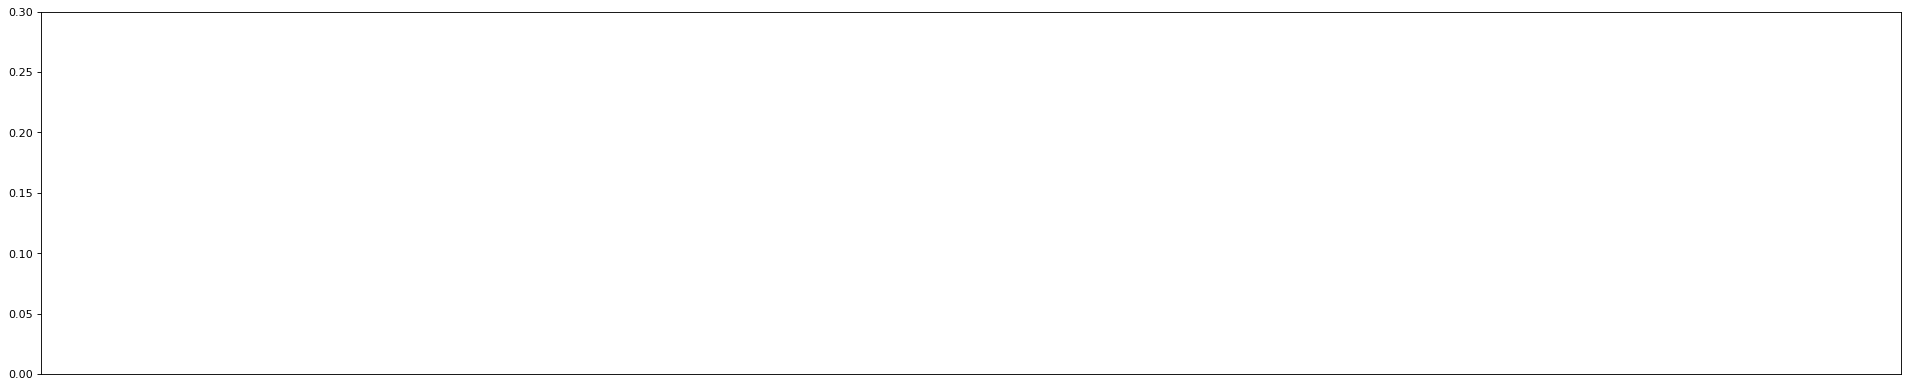

In [44]:
user_map = evaluator(recommender_apr, URM_test)
result = interval_map(user_map, step = 50)
result = normalize_dict(result)
plot_dic(result)

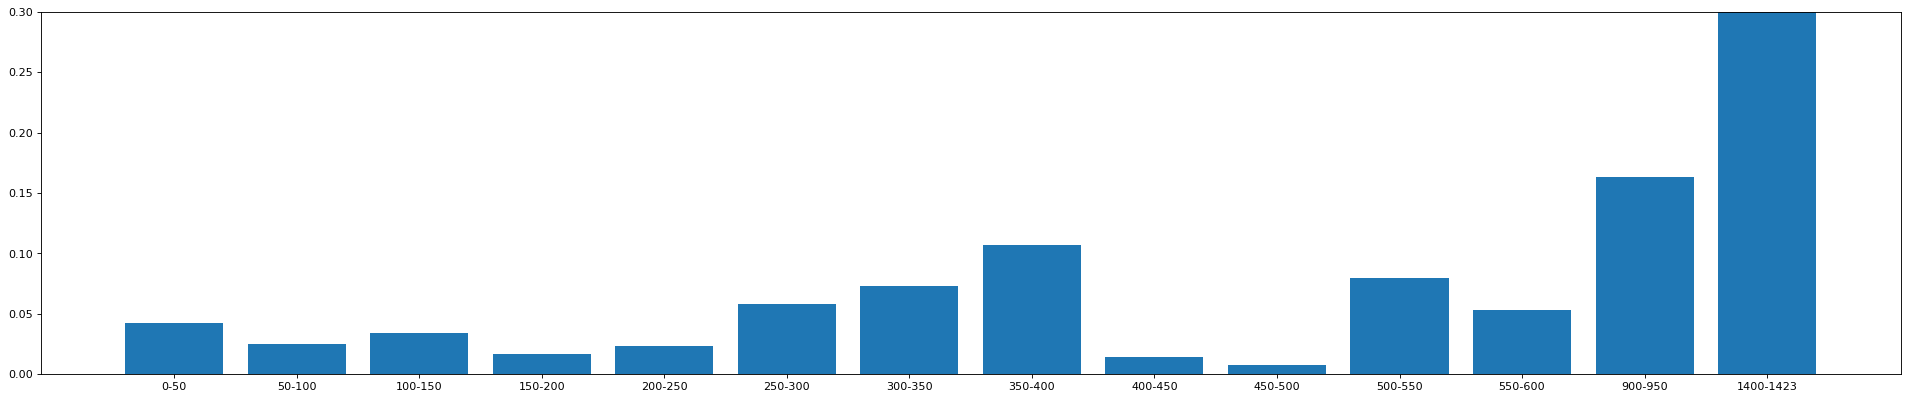

In [36]:
user_map = evaluator(SlimBPR, URM_test)
result = interval_map(user_map, step = 50)
result = normalize_dict(result)
plot_dic(result)

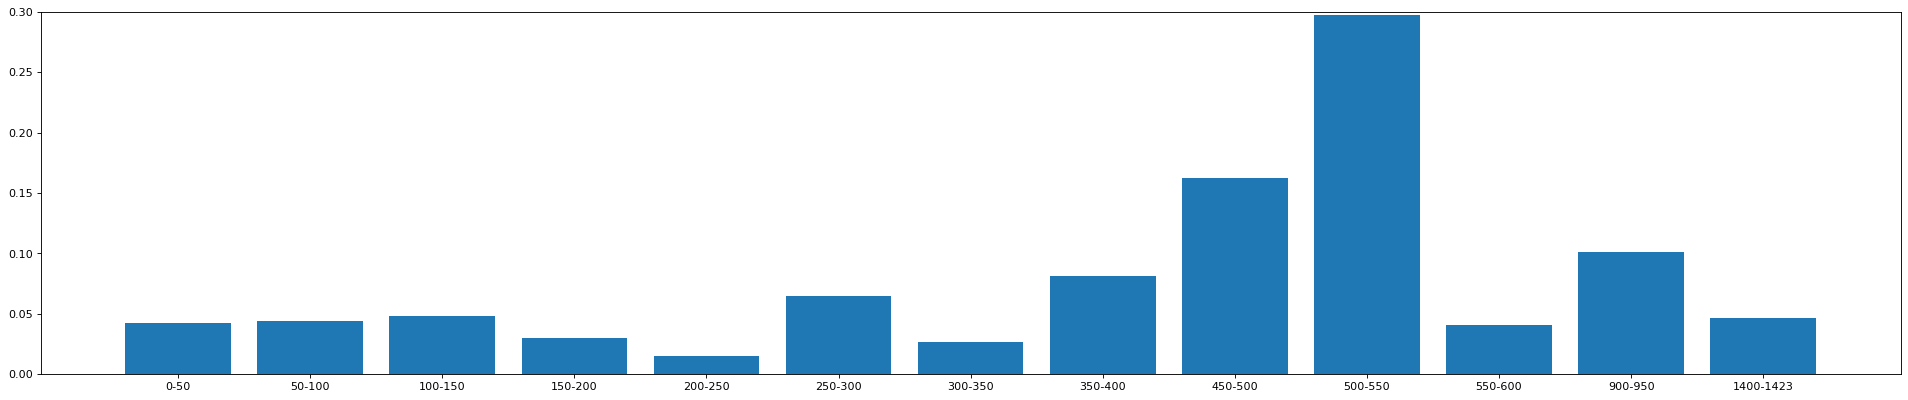

In [37]:
user_map = evaluator(recommender, URM_test)
result = interval_map(user_map, step = 50)
result = normalize_dict(result)
plot_dic(result)

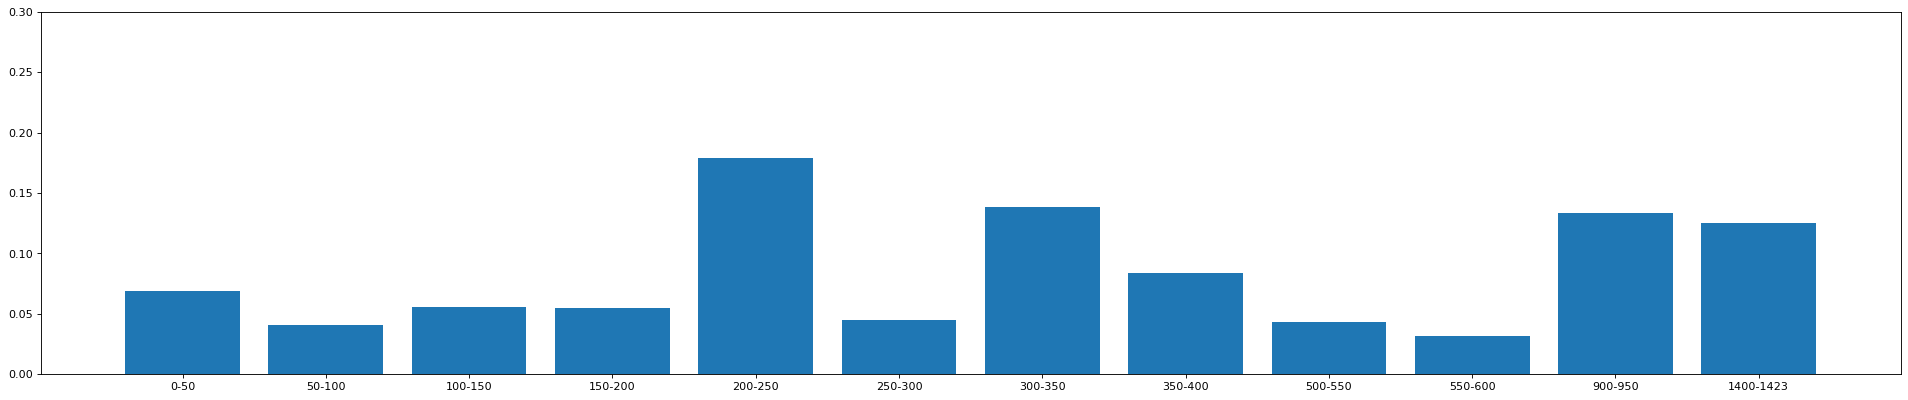

In [38]:
user_map = evaluator(recommender_knn, URM_test)
result = interval_map(user_map, step = 50)
result = normalize_dict(result)
plot_dic(result)